In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, differential_evolution
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import os

# Create output directory if it does not exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Load the gene expression data
data = pd.read_csv('IDHWT.csv')
genes = data['Gene'].values
data = data.drop(columns=['Gene']).values

# Transpose the data to have cells as columns and genes as rows
data = data.T

# Log normalize the counts
data = np.log1p(data)

print("Data shape after log normalization:", data.shape)


Data shape after log normalization: (1943, 23658)


In [ ]:
# Define the drift term F(x)
def drift(x, params):
    return -params[0] * x + params[1]

# Define the noise term σ(x)
def noise(x, params):
    return params[2] * np.random.normal(size=x.shape)

# Langevin dynamics simulation
def langevin_dynamics(x0, params, T, dt):
    t = np.arange(0, T, dt)
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        x[i] = x[i-1] + drift(x[i-1], params) * dt + noise(x[i-1], params) * np.sqrt(dt)
    return x

x0 = np.mean(data, axis=0)
params = [1.0, 0.5, 0.1]
T = 10.0
dt = 0.01
x_simulated = langevin_dynamics(x0, params, T, dt)

# Plot and save the trajectories
plt.figure(figsize=(10, 6))
for i in range(x_simulated.shape[1]):
    plt.plot(x_simulated[:, i], label=f'Gene {i+1}')
plt.xlabel('Time steps')
plt.ylabel('Gene Expression')
plt.legend()
plt.savefig(os.path.join(output_dir, 'trajectories2.png'))
plt.show()


In [4]:
# Define the objective function
def objective_function(params, x0, T, dt, actual_data):
    simulated_data = langevin_dynamics(x0, params, T, dt)
    if simulated_data.shape != actual_data.shape:
        min_length = min(simulated_data.shape[0], actual_data.shape[0])
        simulated_data = simulated_data[:min_length, :]
        actual_data = actual_data[:min_length, :]
    mse = np.mean((simulated_data - actual_data)**2)
    return mse

x0 = np.mean(data, axis=0)
T = 10.0
dt = 0.01
initial_params = [1.0, 0.5, 0.1]
result = minimize(objective_function, initial_params, args=(x0, T, dt, data), method='L-BFGS-B')
optimized_params = result.x
print("Optimized Parameters:", optimized_params)


Optimized Parameters: [0.99999992 0.49999995 0.0999999 ]


In [4]:
bounds = [(0.1, 10), (0.1, 10), (0.01, 1)]
result_de = differential_evolution(objective_function, bounds, args=(x0, T, dt, data))
optimized_params_de = result_de.x
print("Optimized Parameters (DE):", optimized_params_de)

Optimized Parameters (DE): [7.25994451 1.96115408 0.01459527]


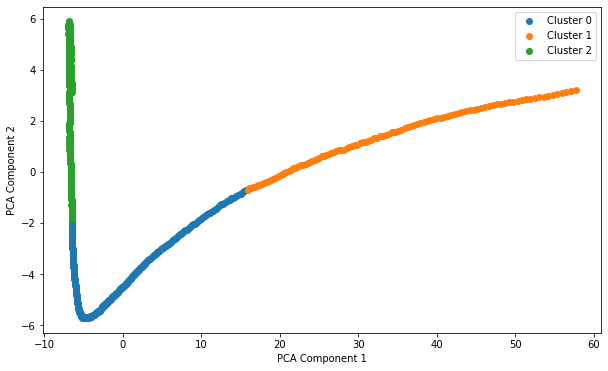

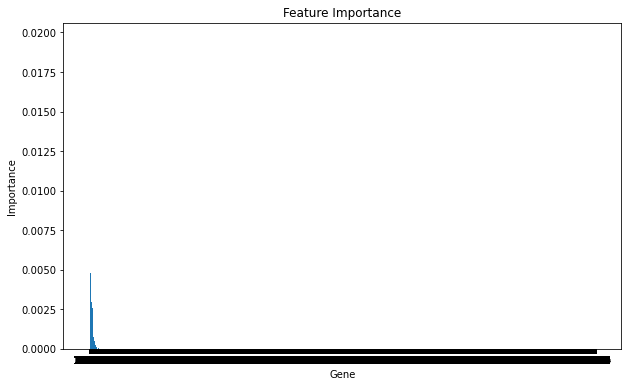

In [5]:
# Simulate the dynamics with optimized parameters
x_simulated = langevin_dynamics(x0, optimized_params, T, dt)
#x_simulated = langevin_dynamics(x0, optimized_params_de, T, dt)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_simulated)

# KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(x_pca)

# Plot and save the clustered trajectories
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(x_pca[clusters == cluster, 0], x_pca[clusters == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.savefig(os.path.join(output_dir, 'clustered_trajectories2.png'))
plt.show()

# Random Forest classifier for feature importance
X = x_simulated
y = clusters
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Save the important genes
important_genes = [genes[i] for i in indices]
importance_scores = importances[indices]

important_genes_df = pd.DataFrame({
    'Gene': important_genes,
    'Importance': importance_scores
})
important_genes_df.to_csv(os.path.join(output_dir, 'important_genes.csv'), index=False)

# Plot and save feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlabel('Gene')
plt.ylabel('Importance')
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.show()


In [8]:
#BDM Perturbation Analysis

import pandas as pd
import numpy as np
from pybdm import BDM
from pybdm.algorithms import PerturbationExperiment
import os
import matplotlib.pyplot as plt

# Create output directory if it does not exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Read all important genes
important_genes_df = pd.read_csv('output/important_genes.csv')
important_genes = important_genes_df['Gene'].values

# Step 2: Read the gene expression data
data = pd.read_csv('IDHWT.csv')

# Extract the counts for the important genes
important_data = data.set_index('Gene').loc[important_genes].values

# Step 3: Log-normalize the counts
important_data_log_normalized = np.log1p(important_data)

# Step 4: Binarize the data using a fixed threshold of 0.1
fixed_threshold = 0.1
important_data_binarized = (important_data_log_normalized >= fixed_threshold).astype(int)

In [9]:
# Step 5: Initialize BDM object
bdm = BDM(ndim=2)

# Step 6: Initialize perturbation experiment object
perturbation = PerturbationExperiment(bdm, important_data_binarized, metric='bdm')

# Compute BDM change for all data points
delta_bdm = perturbation.run()


In [10]:
# Ensure delta_bdm is a 1D array for consistent processing
delta_bdm = delta_bdm.flatten()

# Make sure the lengths of important_genes and delta_bdm match
if len(delta_bdm) > len(important_genes):
    delta_bdm = delta_bdm[:len(important_genes)]
elif len(delta_bdm) < len(important_genes):
    important_genes = important_genes[:len(delta_bdm)]

# Associate delta_bdm values with gene names
perturbation_df = pd.DataFrame({
    'Gene': important_genes,
    'BDM Change': delta_bdm
})

# Sort the genes by BDM Change and get the top 30
top_30_perturbation_df = perturbation_df.sort_values(by='BDM Change', ascending=False).head(30)

# Print the top 30 genes with their BDM Change values
print(top_30_perturbation_df.to_string(index=False))

        Gene  BDM Change
    C6orf195   28.725452
     MIR4488   28.664675
   LINC00520   26.131638
 RPS10-NUDT3   26.005122
       REEP5   25.966545
      POU4F3    1.574712
     MIR517C    1.288459
        TLR9    0.912537
        SELP    0.736966
        NOL8    0.497500
        NACA    0.459432
       GRIP2    0.299560
    C19orf10    0.289507
       ITSN2    0.269461
       RAB1B    0.269461
    TBC1D22A    0.222392
       CHST9    0.222392
        DERA    0.206451
     MIR4471    0.195920
         HBZ    0.191299
       CEP72    0.185032
       PTCH1    0.183122
       TCF12    0.183122
LOC100132831    0.183122
      NDUFA2    0.183122
       DUOX1    0.169925
       RPL27    0.169925
       LYNX1    0.160992
       CIRBP    0.160465
       LAMB3    0.160465


       Gene  BDM Change
   C6orf195   28.725452
    MIR4488   28.664675
  LINC00520   26.131638
RPS10-NUDT3   26.005122
      REEP5   25.966545
     POU4F3    1.574712
    MIR517C    1.288459
       TLR9    0.912537
       SELP    0.736966
       NOL8    0.497500


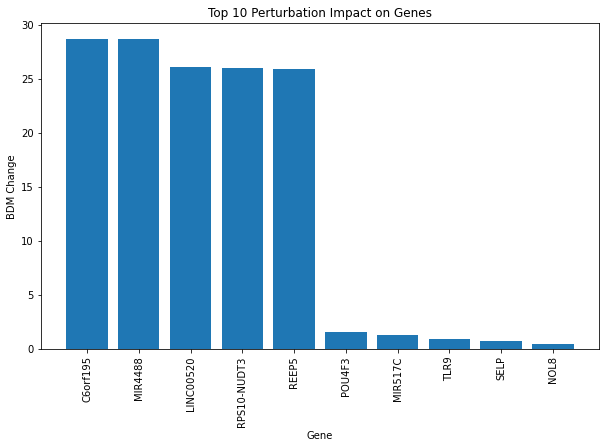

In [11]:
# Ensure delta_bdm is a 1D array for consistent processing
delta_bdm = delta_bdm.flatten()

# Make sure the lengths of important_genes and delta_bdm match
if len(delta_bdm) > len(important_genes):
    delta_bdm = delta_bdm[:len(important_genes)]
elif len(delta_bdm) < len(important_genes):
    important_genes = important_genes[:len(delta_bdm)]

# Associate delta_bdm values with gene names
perturbation_df = pd.DataFrame({
    'Gene': important_genes,
    'BDM Change': delta_bdm
})

# Save the perturbations for all genes
perturbation_df.to_csv(os.path.join(output_dir, 'perturbation_genes.csv'), index=False)

# Sort the genes by BDM Change and get the top 10
top_10_perturbation_df = perturbation_df.sort_values(by='BDM Change', ascending=False).head(10)

# Print the top 30 genes with their BDM Change values
print(top_10_perturbation_df.to_string(index=False))

# Plot the top 10 perturbation scores
plt.figure(figsize=(10, 6))
plt.title("Top 10 Perturbation Impact on Genes")
plt.bar(range(10), top_10_perturbation_df['BDM Change'], align="center")
plt.xticks(range(10), top_10_perturbation_df['Gene'], rotation=90)
plt.xlabel('Gene')
plt.ylabel('BDM Change')
plt.savefig(os.path.join(output_dir, 'top_10_perturbation_impact.png'))
plt.show()